## 1. Importación de librerías y carga del dataset

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import math
import torchsummary as ts
import plotly.express as px
import plotly.subplots as subplots
import plotly.graph_objects as go
import numpy as np
import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
all_tif_images=glob('./images/*_w1_*.tif')
all_fg_images=glob('./foreground/*.png')
image_df=pd.DataFrame([{'gfp_path': f} for f in all_tif_images])
def _get_light_path(in_path):
    w2_path='_w2_'.join(in_path.split('_w1_'))
    glob_str='_'.join(w2_path.split('_')[:-1]+['*.tif'])
    m_files=glob(glob_str)
    if len(m_files)>0:
        return m_files[0]
    else:
        return None

print(image_df.head())

image_df['light_path']=image_df['gfp_path'].map(_get_light_path)
image_df=image_df.dropna()
image_df['base_name']=image_df['gfp_path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
# <plate>_<wellrow>_<wellcolumn>_<wavelength>_<fileid>.tif
# Columns 1-12 are positive controls treated with ampicillin. Columns 13-24 are untreated negative controls.

image_df['plate_rc']=image_df['base_name'].map(lambda x: x.split('_')[6])
image_df['row']=image_df['plate_rc'].map(lambda x: x[0:1])
image_df['column']=image_df['plate_rc'].map(lambda x: int(x[1:]))
image_df['treated']=image_df['column'].map(lambda x: x<13)
image_df['wavelength']=image_df['base_name'].map(lambda x: x.split('_')[7])

image_df['mask_path']=image_df['plate_rc'].map(lambda x: './foreground/{}_binary.png'.format(x))
print('Loaded',image_df.shape[0],'datasets')
image_df.sample(3)

                                            gfp_path
0  ./images/1649_1109_0003_Amp5-1_B_20070424_B02_...
1  ./images/1649_1109_0003_Amp5-1_B_20070424_C02_...
2  ./images/1649_1109_0003_Amp5-1_B_20070424_C20_...
3  ./images/1649_1109_0003_Amp5-1_B_20070424_C06_...
4  ./images/1649_1109_0003_Amp5-1_B_20070424_D23_...
Loaded 100 datasets


,gfp_path,light_path,base_name,plate_rc,row,column,treated,wavelength,mask_path
50,./images/1649_1109_0003_Amp5-1_B_20070424_A06_...,./images/1649_1109_0003_Amp5-1_B_20070424_A06_...,1649_1109_0003_Amp5-1_B_20070424_A06_w1_FE6B61...,A06,A,6,True,w1,./foreground/A06_binary.png
86,./images/1649_1109_0003_Amp5-1_B_20070424_B01_...,./images/1649_1109_0003_Amp5-1_B_20070424_B01_...,1649_1109_0003_Amp5-1_B_20070424_B01_w1_2F4D02...,B01,B,1,True,w1,./foreground/B01_binary.png
32,./images/1649_1109_0003_Amp5-1_B_20070424_A17_...,./images/1649_1109_0003_Amp5-1_B_20070424_A17_...,1649_1109_0003_Amp5-1_B_20070424_A17_w1_C4532A...,A17,A,17,False,w1,./foreground/A17_binary.png


## 2. Análisis exploratorio

Light-field Image Path: ./images/1649_1109_0003_Amp5-1_B_20070424_C04_w2_AB2945CC-33E2-413C-84AC-03475BA65F39.tif
GFP Image Path: ./images/1649_1109_0003_Amp5-1_B_20070424_C04_w1_F86BFEA3-489F-4FF7-A9C8-5C0FADF141DD.tif
Segmented Mask Path: ./foreground/C04_binary.png
Test Image Shape: (520, 696)


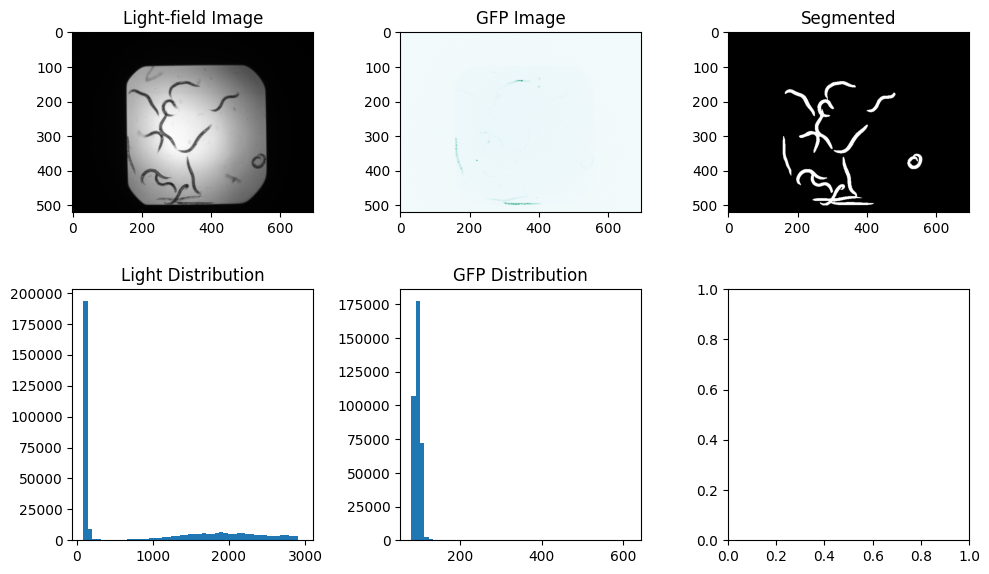

In [3]:
%matplotlib inline
from skimage.io import imread

# Selecciona una muestra tratada al azar del DataFrame
test_image_row = list(image_df.query('treated').sample(1).T.to_dict().values())[0]

# Carga las imágenes asociadas
test_img = imread(test_image_row['light_path'])
test_gfp = imread(test_image_row['gfp_path'])
test_bg = imread(test_image_row['mask_path'])

# Imprime las rutas de las imágenes seleccionadas
print('Light-field Image Path:', test_image_row['light_path'])
print('GFP Image Path:', test_image_row['gfp_path'])
print('Segmented Mask Path:', test_image_row['mask_path'])

# Imprime las dimensiones de la imagen de campo claro como verificación
print('Test Image Shape:', test_img.shape)

# Visualización de las imágenes y distribuciones
fig, ((ax_light, ax_gfp, ax4), (ax2, ax3, _)) = plt.subplots(2, 3, figsize=(10, 6))

# Imagen de campo claro
ax_light.imshow(test_img, cmap='gray')
ax_light.set_title('Light-field Image')

# Imagen GFP
ax_gfp.imshow(np.sqrt(test_gfp), cmap='BuGn')
ax_gfp.set_title('GFP Image')

# Histograma de la distribución de luz de la imagen de campo claro
ax2.hist(test_img.ravel(), bins=50)
ax2.set_title('Light Distribution')

# Histograma de la distribución de luz de la imagen GFP
ax3.hist(test_gfp.ravel(), bins=50)
ax3.set_title('GFP Distribution')

# Imagen de la máscara de segmentación
ax4.imshow(test_bg, cmap='bone')
ax4.set_title('Segmented')

# Ajusta el layout para evitar la superposición de títulos
plt.tight_layout()
plt.show()

In [4]:
print(f"Total de imágenes 'w1': {len(all_tif_images)}")
matched_w2_files = image_df['light_path'].dropna()
print(f"Total de archivos 'w2' encontrados: {len(matched_w2_files)}")

Total de imágenes 'w1': 100
Total de archivos 'w2' encontrados: 100


In [5]:
image_df['light_mean']=image_df['light_path'].map(lambda x: np.mean(imread(x)))
image_df['gfp_mean']=image_df['gfp_path'].map(lambda x: np.mean(imread(x)))
image_df['light_sd']=image_df['light_path'].map(lambda x: np.std(imread(x)))
image_df['gfp_sd']=image_df['gfp_path'].map(lambda x: np.std(imread(x)))
image_df.sample(10)


,gfp_path,light_path,base_name,plate_rc,row,column,treated,wavelength,mask_path,light_mean,gfp_mean,light_sd,gfp_sd
4,./images/1649_1109_0003_Amp5-1_B_20070424_D23_...,./images/1649_1109_0003_Amp5-1_B_20070424_D23_...,1649_1109_0003_Amp5-1_B_20070424_D23_w1_F58FF4...,D23,D,23,False,w1,./foreground/D23_binary.png,831.824782,123.006388,885.170279,143.478776
10,./images/1649_1109_0003_Amp5-1_B_20070424_C09_...,./images/1649_1109_0003_Amp5-1_B_20070424_C09_...,1649_1109_0003_Amp5-1_B_20070424_C09_w1_AC40E2...,C09,C,9,True,w1,./foreground/C09_binary.png,893.589431,98.948270,916.434547,35.340629
8,./images/1649_1109_0003_Amp5-1_B_20070424_B20_...,./images/1649_1109_0003_Amp5-1_B_20070424_B20_...,1649_1109_0003_Amp5-1_B_20070424_B20_w1_142608...,B20,B,20,False,w1,./foreground/B20_binary.png,915.634491,127.358226,948.356663,171.555914
47,./images/1649_1109_0003_Amp5-1_B_20070424_B19_...,./images/1649_1109_0003_Amp5-1_B_20070424_B19_...,1649_1109_0003_Amp5-1_B_20070424_B19_w1_A6860C...,B19,B,19,False,w1,./foreground/B19_binary.png,913.829274,124.488066,948.255798,129.149895
90,./images/1649_1109_0003_Amp5-1_B_20070424_A08_...,./images/1649_1109_0003_Amp5-1_B_20070424_A08_...,1649_1109_0003_Amp5-1_B_20070424_A08_w1_C34F60...,A08,A,8,True,w1,./foreground/A08_binary.png,932.082101,100.056059,940.555856,43.964291
45,./images/1649_1109_0003_Amp5-1_B_20070424_B10_...,./images/1649_1109_0003_Amp5-1_B_20070424_B10_...,1649_1109_0003_Amp5-1_B_20070424_B10_w1_812ED8...,B10,B,10,True,w1,./foreground/B10_binary.png,736.657924,99.225044,776.238098,45.826892
70,./images/1649_1109_0003_Amp5-1_B_20070424_A21_...,./images/1649_1109_0003_Amp5-1_B_20070424_A21_...,1649_1109_0003_Amp5-1_B_20070424_A21_w1_AA440B...,A21,A,21,False,w1,./foreground/A21_binary.png,855.078440,119.693733,907.442890,113.594259
92,./images/1649_1109_0003_Amp5-1_B_20070424_D19_...,./images/1649_1109_0003_Amp5-1_B_20070424_D19_...,1649_1109_0003_Amp5-1_B_20070424_D19_w1_A9AB4F...,D19,D,19,False,w1,./foreground/D19_binary.png,861.523530,121.541600,889.771284,114.641824
73,./images/1649_1109_0003_Amp5-1_B_20070424_A23_...,./images/1649_1109_0003_Amp5-1_B_20070424_A23_...,1649_1109_0003_Amp5-1_B_20070424_A23_w1_081248...,A23,A,23,False,w1,./foreground/A23_binary.png,839.589470,117.228744,879.710502,103.921535
75,./images/1649_1109_0003_Amp5-1_B_20070424_C07_...,./images/1649_1109_0003_Amp5-1_B_20070424_C07_...,1649_1109_0003_Amp5-1_B_20070424_C07_w1_0652E7...,C07,C,7,True,w1,./foreground/C07_binary.png,976.253180,99.236842,979.619597,55.959520


<ipython-input-6-0df393a151b0>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  sns.pairplot(image_df.drop(['column'],1),hue='treated')


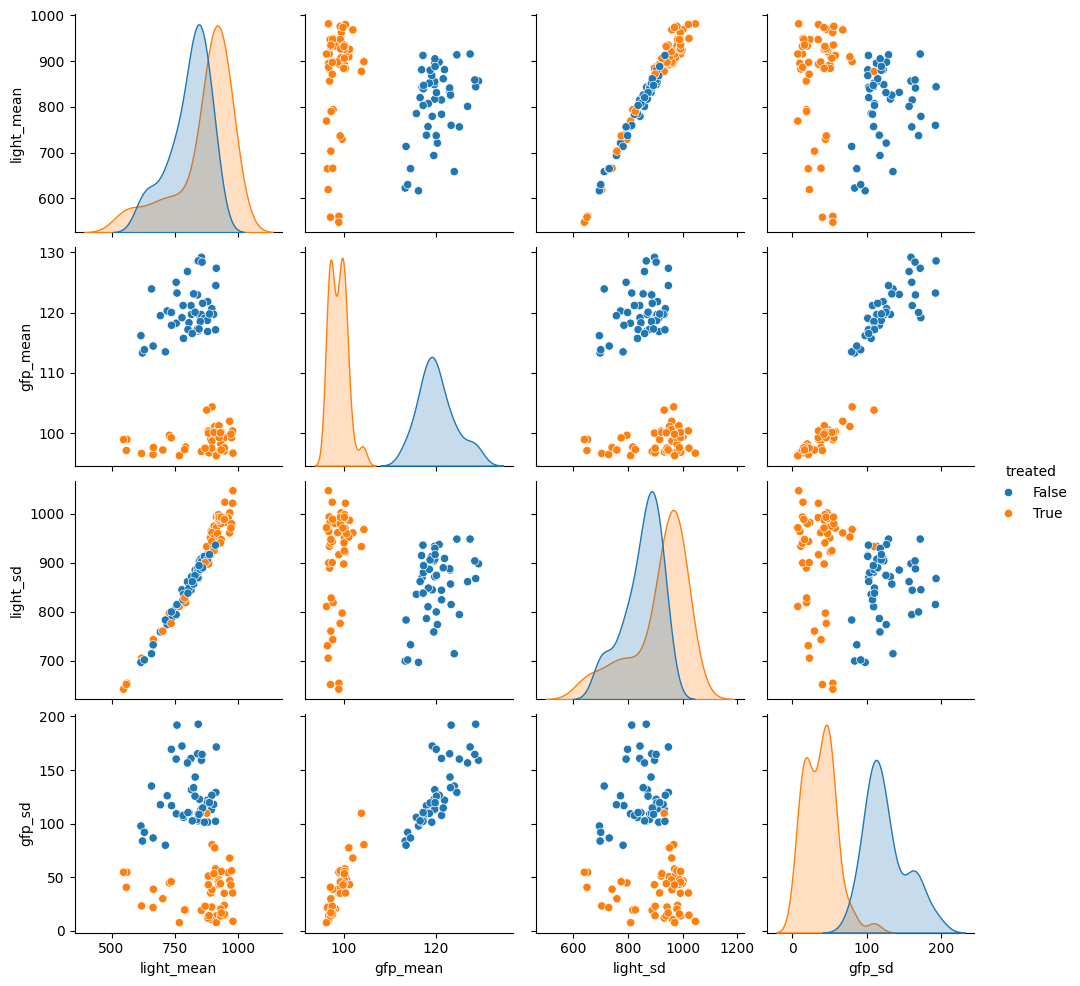

In [6]:
#Mostrar correlaciones

sns.pairplot(image_df.drop(['column'],1),hue='treated')

## 3. Transformación y split de los datos

In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch

class WormsDataset(Dataset):
    def __init__(self, dataframe, image_column='gfp_path', label_column='treated', transform=None):
        """
        Args:
            dataframe (DataFrame): DataFrame que contiene las rutas de las imágenes y las etiquetas.
            image_column (str): Nombre de la columna del DataFrame que contiene las rutas de las imágenes.
            label_column (str): Nombre de la columna del DataFrame que contiene las etiquetas (tratado o no tratado).
            transform (callable, optional): Transformaciones opcionales a aplicar sobre las imágenes.
        """
        self.dataframe = dataframe
        self.image_column = image_column
        self.label_column = label_column
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx][self.image_column]
        image = Image.open(img_path).convert('RGB')  # Convertir a RGB
        label = int(self.dataframe.iloc[idx][self.label_column])

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [8]:
from sklearn.model_selection import train_test_split

# Transformaciones comunes
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Dividir el DataFrame en entrenamiento y prueba
train_df, test_df = train_test_split(image_df, test_size=0.2, random_state=42, stratify=image_df['treated'])

# Crear instancias de WormsDataset para entrenamiento y prueba
train_dataset = WormsDataset(train_df, transform=transform)
test_dataset = WormsDataset(test_df, transform=transform)


In [9]:
print("Número de elementos en el conjunto de entrenamiento:", len(train_df))
print("Número de elementos en el conjunto de prueba:", len(test_df))


Número de elementos en el conjunto de entrenamiento: 80
Número de elementos en el conjunto de prueba: 20


In [10]:
## USANDO DATA AUGMENTATION

from torchvision import transforms

# Transformaciones para el conjunto de entrenamiento
train_transforms = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.RandomHorizontalFlip(),  # Gira las imágenes horizontalmente de manera aleatoria
    transforms.RandomRotation(10),  # Rota las imágenes hasta 10 grados aleatoriamente
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Aplica traslaciones aleatorias
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Modifica el brillo, contraste y saturación
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Transformaciones para el conjunto de prueba (sin data augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Crear instancias de WormsDataset para entrenamiento y prueba con las transformaciones adecuadas
train_dataset = WormsDataset(train_df, transform=train_transforms)
test_dataset = WormsDataset(test_df, transform=test_transforms)


In [11]:
print("Número de elementos en el conjunto de entrenamiento:", len(train_dataset))
print("Número de elementos en el conjunto de prueba:", len(test_dataset))

Número de elementos en el conjunto de entrenamiento: 80
Número de elementos en el conjunto de prueba: 20


In [12]:
# # Calcular la media global y la desviación estándar global para el canal GFP
# gfp_global_mean = image_df['gfp_mean'].mean()
# gfp_global_std = image_df['gfp_sd'].mean()

# print(f'GFP Global Mean: {gfp_global_mean}')
# print(f'GFP Global Std: {gfp_global_std}')


In [13]:
# from sklearn.model_selection import train_test_split

# # Transformaciones comunes
# transform = transforms.Compose([
#     transforms.Resize((96, 96)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[gfp_global_mean / 255.0] * 3,
#                          std=[gfp_global_std / 255.0] * 3)
# ])

# # Dividir el DataFrame en entrenamiento y prueba
# train_df, test_df = train_test_split(image_df, test_size=0.2, random_state=42, stratify=image_df['treated'])

# # Crear instancias de WormsDataset para entrenamiento y prueba
# train_dataset = WormsDataset(train_df, transform=transform)
# test_dataset = WormsDataset(test_df, transform=transform)

## 4. Preparando datos para entrenamiento

In [14]:
# hiper parametros
input_size = 96*96
num_classes = 10
batch_size_train = 64
batch_size_test = 1000
momentum = 0.9
log_interval = 100
learning_rate = 0.001

In [15]:
batch_size_train = 64
batch_size_test = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

In [16]:
# Viendo el tamaño de los tensores
print('Training images:', len(train_dataset))
print('Testing images:', len(test_dataset))

print(type(train_dataset[0])) # tupla(0 => tensor, 1 => label)

print(train_dataset[0][0].shape) # dimension del tensor
print(f'label = {train_dataset[0][1]}') # label

print(len(train_loader)) # nro de batches

print(math.ceil(len(train_dataset)/batch_size_train))

Training images: 80
Testing images: 20
<class 'tuple'>
torch.Size([3, 96, 96])
label = 0
2
2


In [17]:
# Iterando batches
examples = enumerate(test_loader) # Crea un iterador sobre la lista de batches

batchId, (exampleData, exampleTargets) = next(examples) # Obtenemos el siguiente batch
print(f'Numero de batch: {batchId}')
print(exampleData.shape)
print(exampleTargets.shape)

Numero de batch: 0
torch.Size([20, 3, 96, 96])
torch.Size([20])


In [18]:
# Mostramos los primeros 8 elementos del batch con su etiqueta
fig = subplots.make_subplots(2, 4, subplot_titles=[f'Treated: {exampleTargets[i]}' for i in range(8)])

# Mostramos los primeros 8 elementos del batch con su etiqueta
for i in range(8):
  row = i // 4 + 1
  col = i % 4 + 1
  fig.add_trace(px.imshow(exampleData[i][0]).data[0], row, col)

fig.update_yaxes(autorange='reversed')
fig.update_xaxes(scaleanchor='y', scaleratio=1)
fig.update_layout(coloraxis=dict(colorscale='gray_r'))
fig.show()



In [19]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Dispositivo disponible:', device)

Dispositivo disponible: cpu


## 5. Creación y entrenamiento el modelo

In [20]:
import torchvision.models as models
import torch.nn as nn

class AdaptedResNet18_Model(nn.Module):
    def __init__(self, num_classes=2):
        super(AdaptedResNet18_Model, self).__init__()
        # Cargar una ResNet-18 preentrenada
        self.resnet18 = models.resnet18(pretrained=True)

        # Congelar los pesos de todas las capas, excepto la última capa fully connected
        for param in self.resnet18.parameters():
            param.requires_grad = False

        # Reemplazar la última capa fully connected para que coincida con el número de clases objetivo
        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet18(x)


In [21]:
# #Probando con AdaptedEfficientNetB0_Model
# from torchvision.models import efficientnet_b0

# class AdaptedEfficientNetB0_Model(nn.Module):
#     def __init__(self, num_classes=2):  # Para clasificación binaria
#         super(AdaptedEfficientNetB0_Model, self).__init__()
#         # Cargar un EfficientNet-B0 preentrenado
#         self.efficientnet_b0 = efficientnet_b0(pretrained=True)

#         # Congelar los pesos de todas las capas, excepto la última capa fully connected
#         for param in self.efficientnet_b0.parameters():
#             param.requires_grad = False

#         # Reemplazar la última capa fully connected para que coincida con el número de clases objetivo
#         num_ftrs = self.efficientnet_b0.classifier[1].in_features
#         self.efficientnet_b0.classifier[1] = nn.Linear(num_ftrs, num_classes)

#     def forward(self, x):
#         return self.efficientnet_b0(x)


In [22]:
# # #Probando con AdaptedAlexNet_Model
# import torch
# import torch.nn as nn
# from torchvision import models

# class AdaptedAlexNet_Model(nn.Module):
#     def __init__(self, num_classes=2):  # num_classes=2 para clasificación binaria
#         super(AdaptedAlexNet_Model, self).__init__()
#         # Cargar una AlexNet preentrenada
#         self.alexnet = models.alexnet(pretrained=True)

#         # Congelar los pesos de todas las capas, excepto la última capa fully connected
#         for param in self.alexnet.features.parameters():
#             param.requires_grad = False

#         # AlexNet utiliza el módulo 'classifier' que es una secuencia de capas,
#         # donde la última capa fully connected tiene 6 elementos.
#         # Reemplazar la última capa fully connected para que coincida con el número de clases objetivo.
#         num_ftrs = self.alexnet.classifier[6].in_features
#         self.alexnet.classifier[6] = nn.Linear(num_ftrs, num_classes)

#     def forward(self, x):
#         return self.alexnet(x)


In [23]:
# ts.summary(network, (3, 96, 96))

# Definiendo el modelo

network = AdaptedResNet18_Model(num_classes=2)
#network = AdaptedAlexNet_Model(num_classes=2)
#network = AdaptedEfficientNetB0_Model(num_classes=2)
network = network.to(device)

print(network)

from torchsummary import summary
summary(network, (3, 96, 96))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 76.9MB/s]


AdaptedResNet18_Model(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [24]:
import torch

# Define el optimizador y la función de pérdida
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # Usa CrossEntropyLoss para clasificación

# Función para entrenar una época
def train(network, optimizer, criterion, device, train_loader, epoch, log_interval):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Función para testear
def test(network, criterion, device, test_loader):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += criterion(output, target).item()  # Sumar la pérdida; nota el .item()
            pred = output.argmax(dim=1, keepdim=True)  # obtener el índice de la clase máxima
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))


In [25]:
import torch.optim as optim

# Asegúrate de que estas variables estén definidas correctamente
num_epochs = 20  # Define el número de épocas para el entrenamiento
learning_rate = 0.001  # Define la tasa de aprendizaje
momentum = 0.9  # Define el momentum para el optimizador SGD
log_interval = 10  # Define con qué frecuencia quieres lograr la información durante el entrenamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Define el dispositivo

# Inicializa el optimizador
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

# Inicializa la función de pérdida
criterion = nn.CrossEntropyLoss()

# Lleva el modelo al dispositivo adecuado
network.to(device)

# Inicializa las listas para almacenar los valores de pérdida durante el entrenamiento y la prueba
train_losses = []
train_counter = []
test_losses = []

# Lleva a cabo la prueba antes de iniciar el entrenamiento para establecer una línea base
test(network, criterion, device, test_loader)

# Ciclo de entrenamiento
for epoch in range(1, num_epochs + 1):
    train(network, optimizer, criterion, device, train_loader, epoch, log_interval)
    test(network, criterion, device, test_loader)



Test set: Average loss: 0.0397, Accuracy: 10/20 (50%)

Train Epoch: 1 [0/80 (0%)]	Loss: 0.991690

Test set: Average loss: 0.0407, Accuracy: 9/20 (45%)

Train Epoch: 2 [0/80 (0%)]	Loss: 0.783343

Test set: Average loss: 0.0401, Accuracy: 7/20 (35%)

Train Epoch: 3 [0/80 (0%)]	Loss: 0.644266

Test set: Average loss: 0.0394, Accuracy: 6/20 (30%)

Train Epoch: 4 [0/80 (0%)]	Loss: 0.664117

Test set: Average loss: 0.0353, Accuracy: 10/20 (50%)

Train Epoch: 5 [0/80 (0%)]	Loss: 0.580145

Test set: Average loss: 0.0307, Accuracy: 13/20 (65%)

Train Epoch: 6 [0/80 (0%)]	Loss: 0.423390

Test set: Average loss: 0.0268, Accuracy: 13/20 (65%)

Train Epoch: 7 [0/80 (0%)]	Loss: 0.362761

Test set: Average loss: 0.0234, Accuracy: 15/20 (75%)

Train Epoch: 8 [0/80 (0%)]	Loss: 0.481220

Test set: Average loss: 0.0208, Accuracy: 19/20 (95%)

Train Epoch: 9 [0/80 (0%)]	Loss: 0.315921

Test set: Average loss: 0.0180, Accuracy: 20/20 (100%)

Train Epoch: 10 [0/80 (0%)]	Loss: 0.250472

Test set: Average lo

## 6. Predicción

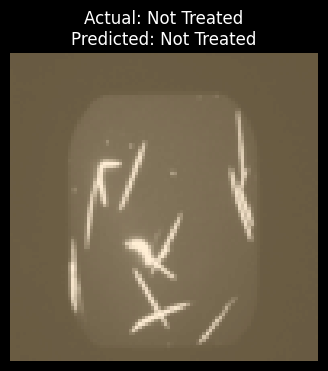

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from PIL import ImageEnhance, Image

def predict_and_visualize_single_example(loader, network, device):
    network.eval()  # Poner el modelo en modo de evaluación
    with torch.no_grad():  # No necesitamos calcular gradientes
        data, target = next(iter(loader))  # Obtener un lote de datos

        # Seleccionar un índice aleatorio dentro del rango del tamaño del lote
        random_index = random.randint(0, data.size(0) - 1)

        data, target = data[random_index].unsqueeze(0).to(device), target[random_index].unsqueeze(0).to(device)
        output = network(data)  # Realizar la predicción
        pred = output.argmax(dim=1)  # Obtener el índice de la mayor puntuación

        # Visualizar la imagen seleccionada aleatoriamente
        img = data[0].cpu().numpy().transpose((1, 2, 0))  # Convertir el tensor a numpy y cambiar CxHxW a HxWxC
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean  # Desnormalizar
        img = np.clip(img, 0, 1)  # Asegurar que los valores estén en el rango [0, 1]

        # Convertir a PIL para ajustar el contraste
        pil_img = Image.fromarray((img * 255).astype(np.uint8))
        contrast_enhancer = ImageEnhance.Contrast(pil_img)
        pil_img_enhanced = contrast_enhancer.enhance(2.0)  # Ajustar el factor de contraste según sea necesario

        # Configurar el fondo oscuro
        plt.figure(figsize=(6, 4))
        plt.imshow(pil_img_enhanced)
        plt.title(f'Actual: {"Treated" if target[0].item() == 1 else "Not Treated"}\nPredicted: {"Treated" if pred[0].item() == 1 else "Not Treated"}', color='white')
        plt.axis('off')  # Ocultar los ejes

        # Establecer el color de fondo
        plt.gca().set_facecolor('black')
        plt.gcf().set_facecolor('black')

        # Cambiar el color de la fuente a blanco para contraste
        plt.rcParams['text.color'] = 'white'

        plt.show()


# Llama a la función para visualizar y predecir un ejemplo
predict_and_visualize_single_example(test_loader, network, device)
